In [1]:
import matplotlib.pyplot as plt

def plot_metrics(metrics_dict):
    """
    Plots the training metrics including loss on the left, 
    and other metrics like accuracy, precision, recall, f1, auc on the right.
    
    Args:
    metrics_dict (dict): A dictionary containing metrics with 'loss' as a key and the rest of the metrics like accuracy, precision, recall, f1, auc.
    """
    
    epochs = list(range(1, len(metrics_dict['loss']) + 1))

    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot Loss on the left y-axis
    ax1.plot(epochs, metrics_dict['loss'], label='Loss', color='blue', linewidth=2)
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.set_title('Loss and Other Metrics over Epochs')

    # Create a second y-axis for the other metrics
    ax2 = ax1.twinx()  
    ax2.plot(epochs, metrics_dict['accuracy'], label='Accuracy', color='green', linestyle='--')
    ax2.plot(epochs, metrics_dict['precision'], label='Precision', color='orange', linestyle='--')
    ax2.plot(epochs, metrics_dict['recall'], label='Recall', color='red', linestyle='--')
    ax2.plot(epochs, metrics_dict['f1_score'], label='F1 Score', color='purple', linestyle='--')
    ax2.plot(epochs, metrics_dict['auc'], label='AUC', color='brown', linestyle='--')

    ax2.set_ylabel('Metrics', color='black')
    ax2.tick_params(axis='y')

    # Add legends
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    plt.tight_layout()
    plt.show()


KeyboardInterrupt: 

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize

import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import scipy.sparse
import json

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix

import torch
from torch_geometric.data import Data
from torch.optim import Adam
import torch.nn.functional as F


# 1. Apply SMOTE
# def apply_smote(X, Y):
#     smote = SMOTE(random_state=42)
#     X_resampled, Y_resampled = smote.fit_resample(X, Y)
#     return X_resampled, Y_resampled

def apply_smote(X, Y):
    # Move the tensors to CPU before converting to NumPy arrays
    X_cpu = X.cpu().numpy()
    Y_cpu = Y.cpu().numpy()

    smote = SMOTE(random_state=42)
    X_resampled, Y_resampled = smote.fit_resample(X_cpu, Y_cpu)

    # Return the resampled data
    return X_resampled, Y_resampled



class ANN_MultiClassClassifier(torch.nn.Module):
    def __init__(self, num_features, hidden_channels=128, num_classes=3):
        super(ANN_MultiClassClassifier, self).__init__()
        # Fully connected layers for multi-class classification
        self.fc1 = nn.Linear(num_features, hidden_channels)
        self.fc2 = nn.Linear(hidden_channels, hidden_channels // 2)
        self.fc3 = nn.Linear(hidden_channels // 2, num_classes)  # Output layer for multi-class classification

    def forward(self, data):
        # Forward pass through the fully connected layers
        x = F.relu(self.fc1(data.x))  # Input features are passed to the ANN
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # Final output without softmax (logits for multi-class classification)
        return x

def load_dict_from_pickle(filename):
    with open(filename, 'rb') as file:
        loaded_dict = pickle.load(file)
    return loaded_dict

def evaluate_multi_class(model, data, mask, num_classes=3):
    model.eval()
    with torch.no_grad():
        logits = model(data)[mask]
        preds = torch.argmax(logits, dim=1).cpu().numpy()  # Get class predictions
        true_labels = data.y[mask].cpu().numpy()

        # Binarize the true labels for multi-class AUC calculation
        true_labels_binarized = label_binarize(true_labels, classes=np.arange(num_classes))

        # Get class probabilities by applying softmax to the logits
        probs = torch.softmax(logits, dim=1).cpu().numpy()

        try:
            # Calculate AUC for each class and then macro-average
            auc = roc_auc_score(true_labels_binarized, probs, average='macro', multi_class='ovr')
        except ValueError:
            # Handle cases where AUC cannot be calculated
            auc = None

        accuracy = accuracy_score(true_labels, preds)
        precision = precision_score(true_labels, preds, average='weighted')
        recall = recall_score(true_labels, preds, average='weighted')
        f1 = f1_score(true_labels, preds, average='weighted')

        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'auc': auc  # AUC may be None if not computable
        }


def prepare_masks(X, Y, train_size=0.8, val_size=0.1, test_size=0.1, random_state=42):
    from sklearn.model_selection import train_test_split
    import torch
    
    # Ensure the sizes are correct
    assert len(X) == len(Y), "X and Y must have the same length"
    
    # Create indices for the full dataset
    indices = np.arange(len(X))
    
    # First, split into train and temp (val + test)
    train_indices, temp_indices = train_test_split(indices, train_size=train_size, random_state=random_state)
    
    # Then split the temp set into validation and test sets
    val_indices, test_indices = train_test_split(temp_indices, test_size=test_size/(test_size + val_size), random_state=random_state)
    
    # Initialize masks for all data points
    train_mask = torch.zeros(len(X), dtype=torch.bool)
    val_mask = torch.zeros(len(X), dtype=torch.bool)
    test_mask = torch.zeros(len(X), dtype=torch.bool)

    # Set the appropriate indices to True
    train_mask[train_indices] = True
    val_mask[val_indices] = True
    test_mask[test_indices] = True

    return train_mask, val_mask, test_mask

def train(model, data, train_mask, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    out = model(data)  # Forward pass
    loss = criterion(out[train_mask], data.y[train_mask].long())  # Compute loss
    loss.backward()  # Backward pass
    optimizer.step()  # Update weights
    return loss.item()

def load_data(file_path, device):

    Nodes = load_dict_from_pickle(f'../Data/{file_path}/Nodes.pkl')
    X = torch.load(f'../Data/{file_path}/X.pt')
    Y = torch.load(f'../Data/{file_path}/Y.pt')
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    
    if isinstance(X, scipy.sparse.csr_matrix) or isinstance(X, scipy.sparse.csr_array):
        X = torch.tensor(X.toarray(), dtype=torch.float).to(device)  # Convert sparse matrix to dense and then to tensor
    else:
        X = X.to(device)

    return X, Y, Nodes


def main(DISEASE_FILE, num_epochs, lr=1e-5, exp_name='ann_result', num_D=10):
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    X, Y, Nodes = load_data(DISEASE_FILE, device)
    
    print(X.shape, Y.shape)

    # Apply SMOTE to oversample the minority class
    X_resampled, Y_resampled = apply_smote(X, Y)

    # Convert resampled X and Y back to tensors
    X_resampled = torch.tensor(X_resampled, dtype=torch.float).to(device)
    Y_resampled = torch.tensor(Y_resampled, dtype=torch.float).to(device)

    data = Data(x=X_resampled, y=Y_resampled)
    
    # Prepare masks (you can apply the new prepare_masks on the resampled data)
    train_mask, val_mask, test_mask = prepare_masks(X_resampled, Y_resampled)
    data.train_mask = train_mask.to(device)
    data.val_mask = val_mask.to(device)
    data.test_mask = test_mask.to(device)

    num_features = X_resampled.size(1)
    
    # Initialize the ANN model
    model = ANN_MultiClassClassifier(num_features, hidden_channels=128).to(device)

    # Optimizer and criterion (for multi-class classification)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)

    # Class imbalance adjustment with CrossEntropyLoss
    criterion = torch.nn.CrossEntropyLoss()

    print(f"Class distribution: {torch.sum(data.y == 0)}, {torch.sum(data.y == 1)}")
    metrics_dict = {'loss': [],'accuracy': [],'precision': [],'recall': [],'f1_score': [],'auc': []}
    
    # Training loop
    for epoch in range(1, num_epochs + 1):
        model.train()
        optimizer.zero_grad()
        out = model(data).squeeze(1)  # Forward pass
        
        # Convert target labels to Long type for CrossEntropyLoss
        loss = criterion(out[data.train_mask], data.y[data.train_mask].long())  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        # Evaluate on validation set
        val_metrics = evaluate_multi_class(model, data, val_mask, num_classes=3)

        # Save the metrics for this epoch
        metrics_dict['loss'].append(loss.item())
        metrics_dict['accuracy'].append(val_metrics['accuracy'])
        metrics_dict['precision'].append(val_metrics['precision'])
        metrics_dict['recall'].append(val_metrics['recall'])
        metrics_dict['f1_score'].append(val_metrics['f1_score'])
        
        if val_metrics['auc'] is not None:
            metrics_dict['auc'].append(val_metrics['auc'])
        else:
            metrics_dict['auc'].append(0)
    
        print(f'Epoch {epoch}/{num_epochs}, Loss: {loss.item():.4f}, Accuracy: {val_metrics["accuracy"]:.4f}, Precision: {val_metrics["precision"]:.4f}, Recall: {val_metrics["recall"]:.4f}, F1: {val_metrics["f1_score"]:.4f}, AUC: {val_metrics["auc"]}')

    # Final evaluation on test set
    test_metrics = evaluate_multi_class(model, data, test_mask, num_classes=3)
    print(json.dumps(test_metrics, indent=4))
    return metrics_dict



# Set parameters and run the main training process
num_Labels = 203
DISEASE_FILE = 'infectious'
num_epochs = 250

metrics_dict = main(DISEASE_FILE, num_epochs, lr=1e-5)


/lustre/home/almusawiaf/.local/lib/python3.11/site-packages/torch_geometric/typing.py:72: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: libcudart.so.11.0: cannot open shared object file: No such file or directory
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/lustre/home/almusawiaf/.local/lib/python3.11/site-packages/torch_geometric/typing.py:110: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: libcudart.so.11.0: cannot open shared object file: No such file or directory
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "
/lustre/home/almusawiaf/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch.Size([19442, 1456]) torch.Size([19442])
Class distribution: 11672, 11672


/lustre/home/almusawiaf/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/250, Loss: 1.1090, Accuracy: 0.3692, Precision: 0.4322, Recall: 0.3692, F1: 0.2419, AUC: 0.770058115266748
Epoch 2/250, Loss: 1.0866, Accuracy: 0.5851, Precision: 0.5418, Recall: 0.5851, F1: 0.4652, AUC: 0.7993169411966234
Epoch 3/250, Loss: 1.0739, Accuracy: 0.5808, Precision: 0.6021, Recall: 0.5808, F1: 0.5181, AUC: 0.8074986816897622
Epoch 4/250, Loss: 1.0587, Accuracy: 0.5645, Precision: 0.5952, Recall: 0.5645, F1: 0.5354, AUC: 0.8135986406188979
Epoch 5/250, Loss: 1.0404, Accuracy: 0.5568, Precision: 0.6085, Recall: 0.5568, F1: 0.5206, AUC: 0.8179606439974526
Epoch 6/250, Loss: 1.0194, Accuracy: 0.5483, Precision: 0.6082, Recall: 0.5483, F1: 0.5001, AUC: 0.8209012640032093
Epoch 7/250, Loss: 0.9973, Accuracy: 0.5580, Precision: 0.6213, Recall: 0.5580, F1: 0.5076, AUC: 0.8230676525341836
Epoch 8/250, Loss: 0.9746, Accuracy: 0.5662, Precision: 0.6279, Recall: 0.5662, F1: 0.5177, AUC: 0.8250016181745483
Epoch 9/250, Loss: 0.9514, Accuracy: 0.5765, Precision: 0.6368, Recall: 0

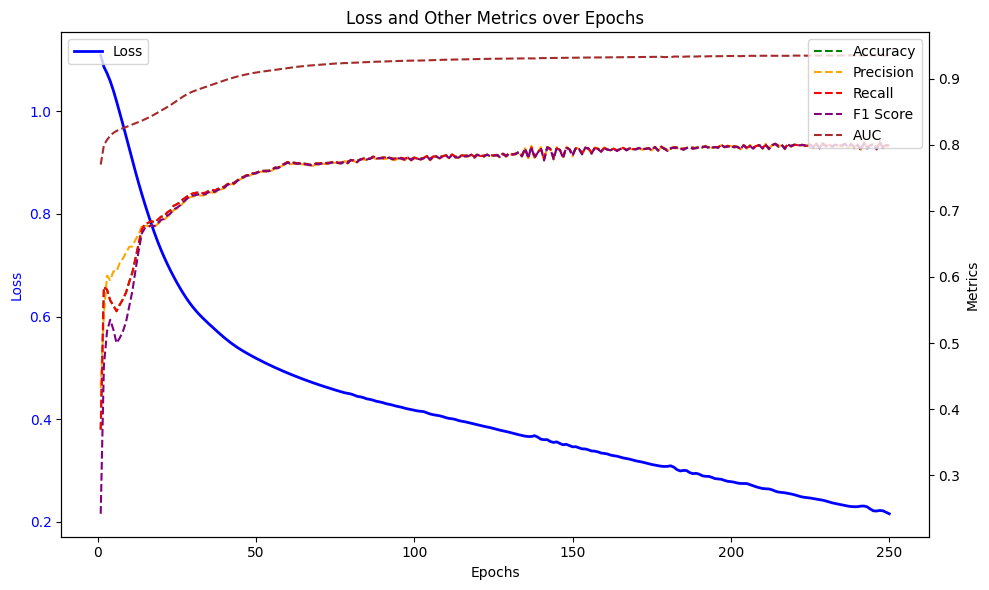

In [ ]:
plot_metrics(metrics_dict)